In [1]:
!pip install openpyxl
!pip install pandas-gbq -U
!pip install tableone
!pip install pydata-google-auth


In [2]:
import pandas as pd
import sklearn as sk
from xgboost import XGBClassifier, XGBRegressor
import numpy as np
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
from sklearn.metrics import r2_score, mean_absolute_error
from fairlearn.metrics import equalized_odds_ratio, demographic_parity_ratio
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import warnings
import shap
from tableone import tableone
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier
import pydata_google_auth
import seaborn as sns
from imblearn.pipeline import Pipeline
import pandas_gbq
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder, 
    PowerTransformer, 
    QuantileTransformer, 
    RobustScaler, 
    MinMaxScaler
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector


warnings.filterwarnings("ignore")

In [3]:
credentials = pydata_google_auth.get_user_credentials(['https://www.googleapis.com/auth/cloud-platform'],)
project = 'capacheiv'
pandas_gbq.context.credentials = credentials

In [4]:
query = ""
for fn in ['icustays', 'apache_vars', 'vitals', 'apache_pt_results', 'sepsis']:
    with open('sql_copy/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from sepsis"
project = 'capacheiv'

gbq_data = pd.read_gbq(query, dialect='standard', project_id=project)

In [5]:
query = ""
for fn in ['icustays', 'apache_vars', 'vitals', 'apache_pt_results', 'sepsis']:
    with open('sql_new/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from sepsis"
project = 'capacheiv'

gbq_data_new = pd.read_gbq(query, dialect='standard', project_id=project)

In [7]:
df_old = gbq_data
df_new = gbq_data_new

In [8]:
df_new.columns

Index(['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age',
       'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx',
       'admissionheight', 'hospitaladmityear', 'hospitaladmittime24',
       'hospitaladmittime', 'hospitaladmitoffset', 'hospitaladmitsource',
       'hospitaldischargeyear', 'hospitaldischargetime24',
       'hospitaldischargetime', 'hospitaldischargeoffset',
       'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype',
       'unitadmityear', 'unitadmittime24', 'unitadmittime', 'unitadmitsource',
       'unitvisitnumber', 'unitstaytype', 'admissionweight', 'dischargeweight',
       'unitdischargeyear', 'unitdischargetime24', 'unitdischargetime',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'uniquepid', 'age_num', 'male', 'female', 'HOSP_NUM', 'teachingstatus',
       'region', 'n_bed', 'intubated', 'vent', 'dialysis', 'eyes', 'motor',
       'verbal', 'meds', 'urine', 'wbc', 'temperature', 'res

In [9]:
df = pd.concat([df_old, df_new], axis=0, ignore_index=True)


In [10]:
df = df[df['has_sepsis'] == 1]

In [11]:
len(df)

27559

In [12]:
df['set'] = df['hospitaldischargeyear'].apply(
    lambda x: 'train' if x in [2014] else(
        'val_15' if x == 2015 else(
            'val_20' if x == 2020 else(
              'val_21' if x==2021 else np.nan
            ) 
        )
    )
)



In [13]:
df = df.dropna(subset=['hospitaldischargeyear', 'hosp_los', 'hosp_mortality', 'set', 'age_num', 'ethnicity', 'region'])

In [14]:
len(df)

26296

In [15]:
df['los_7d'] = df['hosp_los'].apply(lambda x: 1 if x >= 7 else 0)
df['ethnicity'] = df['ethnicity'].replace({'Black/African American': 'African American',
                                           '': 'Other/Unknown',
                                           'Native American':'Indigenous/Native'})
df = df.fillna({'ethnicity':'Other/Unknown'})


In [16]:
df['ethnicity'].value_counts()

ethnicity
Caucasian            20241
African American      2728
Other/Unknown         1782
Hispanic               930
Asian                  430
Indigenous/Native      185
Name: count, dtype: int64

In [17]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Index: 26296 entries, 0 to 159409
Data columns (total 84 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patientunitstayid          26296 non-null  Int64  
 1   patienthealthsystemstayid  26296 non-null  Int64  
 2   gender                     26296 non-null  object 
 3   age                        26296 non-null  object 
 4   ethnicity                  26296 non-null  object 
 5   hospitalid                 26296 non-null  Int64  
 6   wardid                     26296 non-null  Int64  
 7   apacheadmissiondx          26284 non-null  object 
 8   admissionheight            26062 non-null  float64
 9   hospitaladmittime24        26296 non-null  object 
 10  hospitaladmitoffset        26296 non-null  Int64  
 11  hospitaladmitsource        23736 non-null  object 
 12  hospitaldischargeyear      26296 non-null  Int64  
 13  hospitaldischargetime24    26296 non-null  object 

In [18]:
df[['hospitaldischargeyear', 'hosp_los', 'hosp_mortality', 'set', 'age_num', 'ethnicity', 'region']].isna().sum()

hospitaldischargeyear    0
hosp_los                 0
hosp_mortality           0
set                      0
age_num                  0
ethnicity                0
region                   0
dtype: int64

<Axes: >

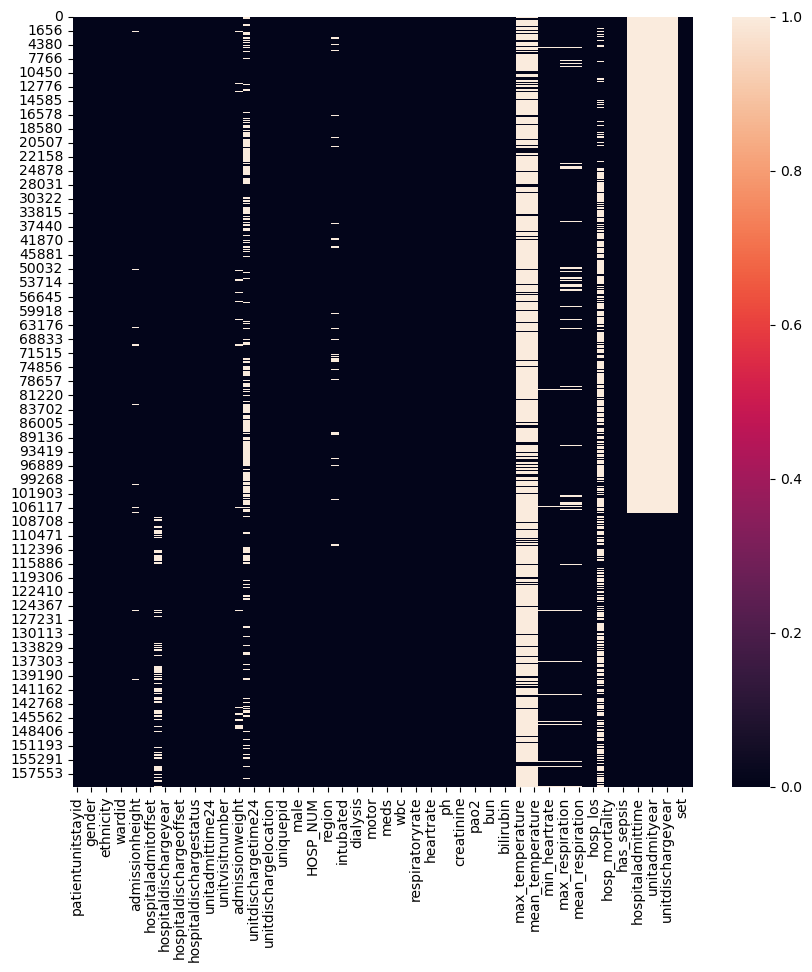

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(df.isna().astype(np.int64))

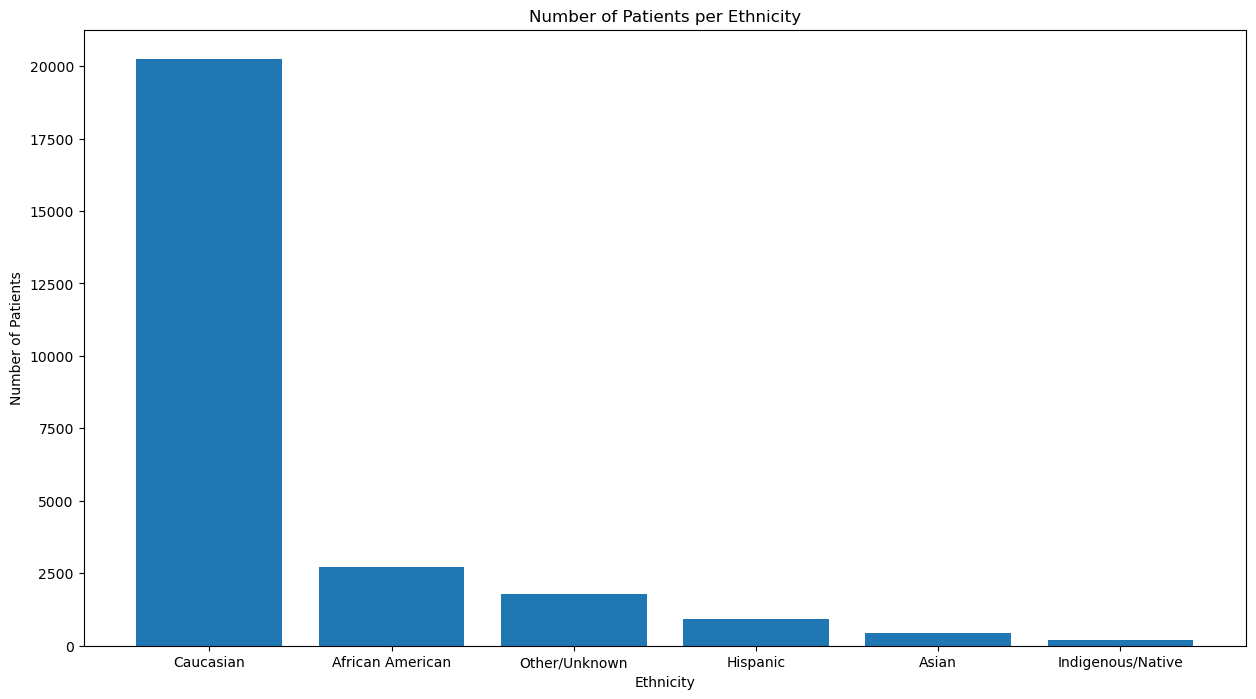

In [20]:
ethincity_counts = df['ethnicity'].value_counts()

plt.figure(figsize=(15, 8)) 
plt.bar(ethincity_counts.index, ethincity_counts.values,)
plt.title('Number of Patients per Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Patients')
plt.show()

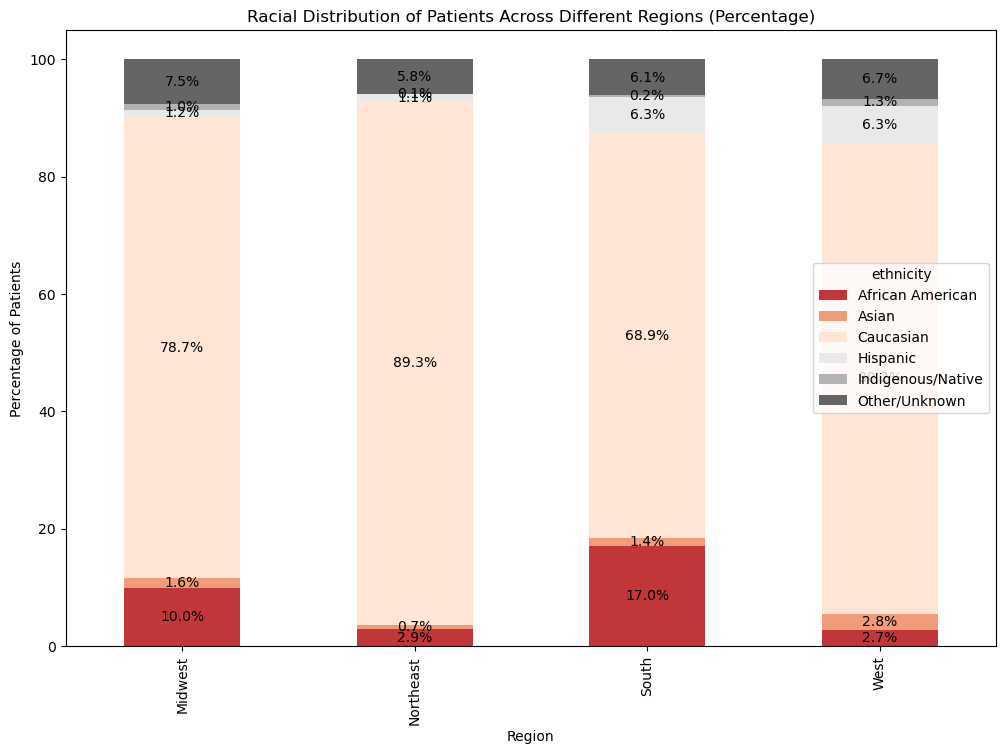

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'set' and 'ethnicity', then calculate the percentage for each race
grouped = df.groupby(['region', 'ethnicity']).size().unstack(fill_value=0)
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart
ax = grouped_percentage.plot(
    kind='bar', stacked=True, color=sns.color_palette('RdGy'), figsize=(12, 8))

plt.xlabel('Region')
plt.ylabel('Percentage of Patients')
plt.title('Racial Distribution of Patients Across Different Regions (Percentage)')

# Annotate each bar segment with the percentage
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2

    # Adding the percentage text with black color
    percentage = f'{height:.1f}%'
    ax.text(x, y, percentage, ha='center', va='center', fontsize=10, color='black')

plt.show()


In [22]:
len(df)

26296

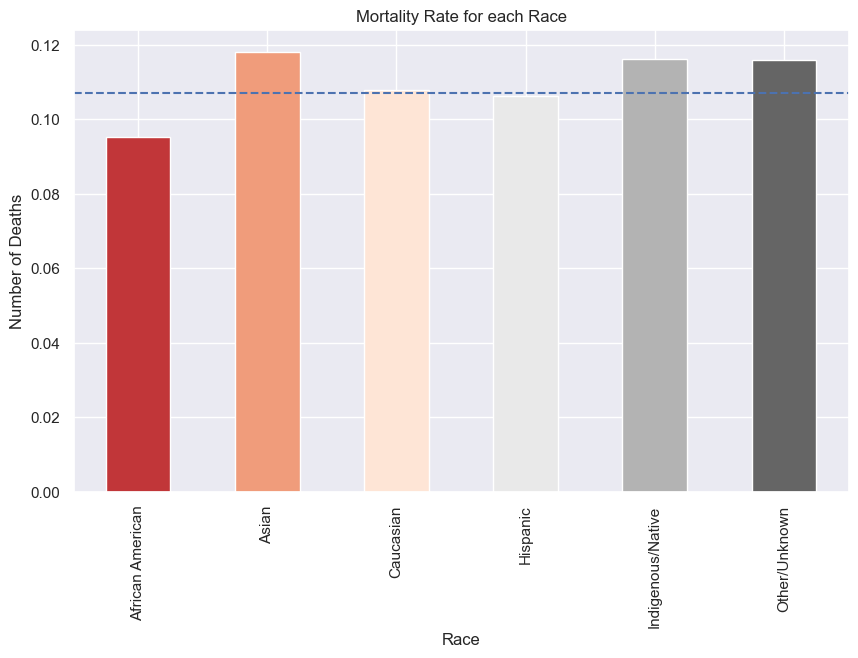

In [131]:
plt.figure(figsize=(10, 6))
df.groupby('ethnicity')['hosp_mortality'].mean().plot(kind='bar', color=sns.color_palette('RdGy'))

plt.xlabel('Race')
plt.ylabel('Number of Deaths')
plt.title('Mortality Rate for each Race')
plt.axhline(y=df['hosp_mortality'].mean(),linestyle='--')

# Show the plot
plt.show()

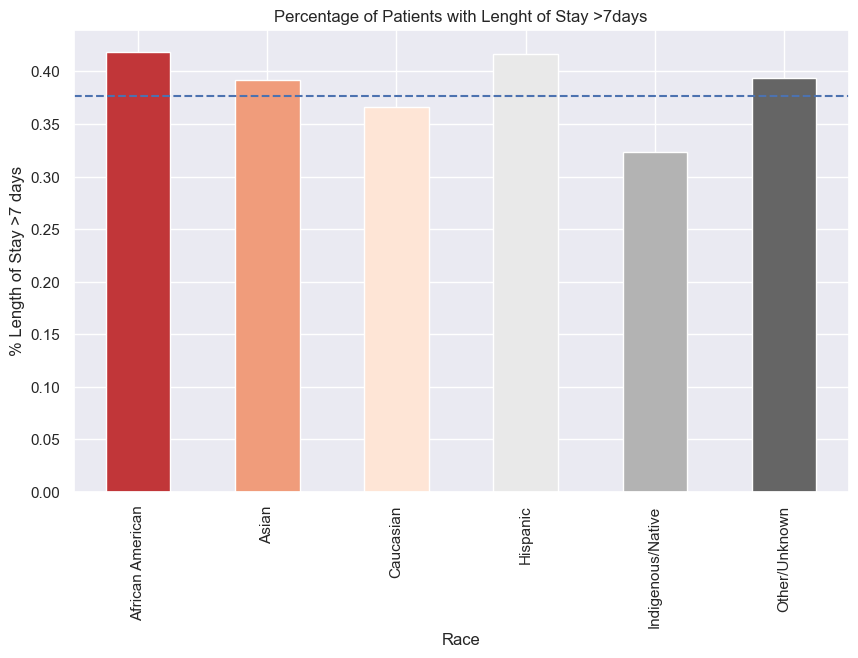

In [132]:
plt.figure(figsize=(10, 6))
df.groupby('ethnicity')['los_7d'].mean().plot(kind='bar', color=sns.color_palette('RdGy'))

plt.xlabel('Race')
plt.ylabel('% Length of Stay >7 days')
plt.title('Percentage of Patients with Lenght of Stay >7days')
plt.axhline(y=df['los_7d'].mean(),linestyle='--')

# Show the plot
plt.show()

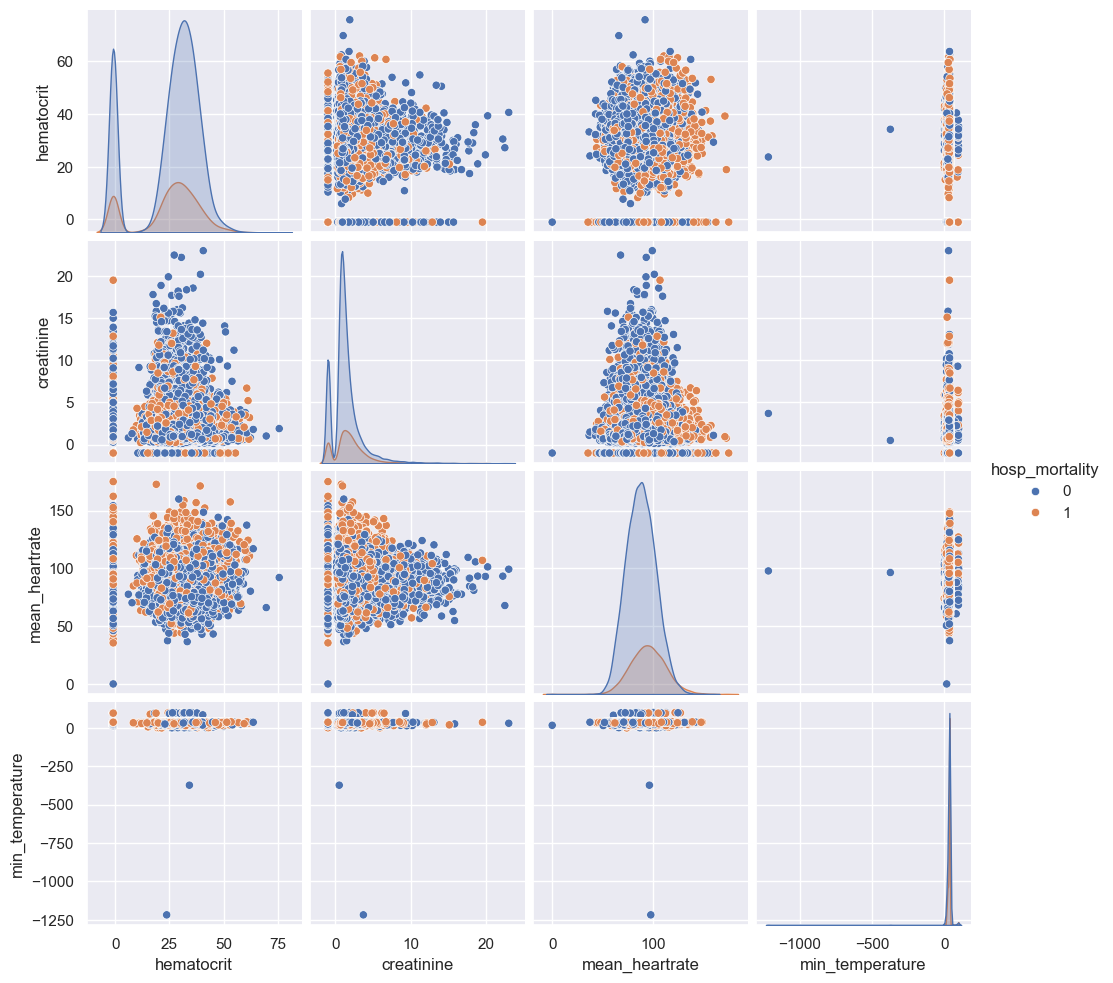

In [23]:
sns.set(font_scale=1)
sns.pairplot(df.loc[:,['hematocrit','creatinine','mean_heartrate','min_temperature','hosp_mortality']],
             hue='hosp_mortality')

In [ ]:
df = df.drop(columns=[ 'patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age',
       'hospitalid', 'wardid', 'apacheadmissiondx',
       'admissionheight', 'hospitaladmittime24', 'hospitaladmitoffset',
       'hospitaladmitsource', 'hospitaldischargeyear',
       'hospitaldischargetime24', 'hospitaldischargeoffset',
       'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype',
       'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype',
       'admissionweight', 'dischargeweight', 'unitdischargetime24',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'uniquepid','HOSP_NUM', 'teachingstatus', 'n_bed', 'eyes', 'motor',
       'verbal', 'meds', 'icu_los', 'hosp_los',
       'daysonvent', 'icu_mortality', 'hospitaladmityear',
       'hospitaladmittime', 'hospitaldischargetime', 'unitadmityear',
       'unitadmittime', 'unitdischargeyear', 'unitdischargetime',
        'max_temperature', 'min_temperature', 'mean_temperature',
        'max_heartrate','min_heartrate','mean_heartrate','max_respiration','min_respiration', 'mean_respiration', 'has_sepsis'])

In [ ]:
tableone(df,
         groupby='set',
         columns=['hosp_mortality','los_7d','ethnicity', 'region'],
         order={'hosp_mortality':[1,0],'los_7d':[1,0]},
         limit={'hosp_mortality': 1,'los_7d': 1},
        )

In [ ]:
def compute_metrics_long_format(y_true,
                                y_pred_proba,
                                seed,
                                target,
                                val_set,
                                sens_attributes,
                                c_test_sens
                               ):
    results = []
    
    for sens_attribute in sens_attributes:
        c_test = c_test_sens[sens_attribute]
    
        unique_classes = c_test.unique()
    
        metrics_list = [
            'AUROC',
            # 'AUPRC',
            'Accuracy',
            'Recall',
            # 'Precision',
            'F1-score',
            # 'Balanced Accuracy'
        ]
        
        functions_list = [
            roc_auc_score,
            # average_precision_score,
            accuracy_score,
            recall_score,
            # precision_score,
            f1_score,
            # balanced_accuracy_score
        ]
    
        for cls in unique_classes:
            idx = c_test == cls
            for metric, func in zip(metrics_list, functions_list):
                try:
                    value = func(y_true[idx], (y_pred_proba[idx] > 0.5).astype(int)) \
                                               if metric not in ['AUROC','AUPRC'] else func(y_true[idx], y_pred_proba[idx])
                except:
                    value = np.nan
                
                results.append({
                    'Task': target,
                    'Validation Set': val_set,
                    'Seed': seed,
                    'Attribute': sens_attribute,
                    'Class': cls,
                    'Metric': metric,
                    'Value': value
                })
    
        # Compute metrics for all classes combined    
        overall_metrics = {}
        for metric, func in zip(metrics_list, functions_list):
            overall_metrics[metric] = func(y_true, (y_pred_proba > 0.5).astype(float))\
                                           if metric not in ['AUROC','AUPRC'] else func(y_true, y_pred_proba)
    
        for metric, value in overall_metrics.items():
            results.append({
                'Task': target,
                'Validation Set': val_set,
                'Seed': seed,
                'Attribute': '',
                'Class': 'Overall',
                'Metric': metric,
                'Value': value
            })
    
        # compute fairness metrics as well
        fairness_metrics = {}
        
        fairness_metrics_list = [
            'Demographic Parity Ratio',
            'Equalized Odds Ratio'
        ]
        
        fairness_functions_list = [
            demographic_parity_ratio,
            equalized_odds_ratio
        ]
    
        for metric, func in zip(fairness_metrics_list, fairness_functions_list):
            fairness_metrics[metric] = func(y_true=y_true,
                                            y_pred=(y_pred_proba > 0.5).astype(int),
                                            sensitive_features=c_test)
    
        for metric, value in fairness_metrics.items():
            results.append({
                'Task': target,
                'Validation Set': val_set,
                'Seed': seed,
                'Attribute': sens_attribute,
                'Class': 'Overall',
                'Metric': metric,
                'Value': value
            })

    return pd.DataFrame(results)

In [ ]:
def get_sample_weights(y_train):
    
    classes_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train
    )
    
    sample_weights = np.ones(y_train.shape[0], dtype = 'float')
    for i, val in enumerate(y_train):
        sample_weights[i] = classes_weights[int(val)]

    return sample_weights

In [ ]:
def train_model(df,
                features,
                target='hosp_mortality',
                model=XGBClassifier(),
               ):
    
    X_train = df.loc[df['set'] == 'train', features]
    y_train = df.loc[df['set'] == 'train', target]

    # Train, test, eval model with sample weights
    model.fit(X_train, y_train, sample_weight=get_sample_weights(y_train))
    
    return model


def test_model(df,
               features,
               metrics_all,
               model,
               target='hosp_mortality',
               val_set=['val_15', 'val_20', 'val_21'],
               sens_attributes=['ethnicity', 'region'],
               seed=42,
              ):


    X_test = df.loc[df['set'] == val_set, features]
    y_test = df.loc[df['set'] == val_set, target]
    
    np.random.seed(s)
    resample = np.random.randint(0, len(X_test), size=int(.8*len(X_test)))

    X_test = X_test.iloc[resample]
    y_test = y_test.iloc[resample]

    # classes of sensitive attributes in the test set
    c_test_sens = df.loc[df['set'] == val_set, sens_attributes].iloc[resample]

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metrics_fold = compute_metrics_long_format(y_test, y_pred_proba, seed,
                                               target, val_set, sens_attributes, 
                                               c_test_sens)

    metrics_all = pd.concat([metrics_all, metrics_fold], axis=0)

    return metrics_all.drop_duplicates()
    

In [ ]:
def mean_ci_agg(df):
    mean = np.mean(df)
    se = np.std(df) / np.sqrt(len(df))
    ci_width = 1.96 * se
    lower_ci = mean - ci_width
    upper_ci = mean + ci_width
    return f"{mean:.3f} ({lower_ci:.3f} - {upper_ci:.3f})"

In [ ]:
def compute_p_value(group):
    group_labels = group['Validation Set'].unique()
    group_values = [group[group['Validation Set'] == label]['Value'] for label in group_labels]
    
    _, p_value = ttest_ind(*group_values)  

    if p_value < .001:
        return '<.001'
    elif p_value < .01:
        return '<.01'
    else:
        return np.round(p_value, 3)

In [ ]:
def calculate_md(group):
    group_labels = group['Validation Set'].unique()
    group_values = [group[group['Validation Set'] == label]['Value'] for label in group_labels]

    mean_diff = np.mean(group_values[1]) - np.mean(group_values[0])

    return mean_diff

In [ ]:
def process_metrics(metrics_all):
    
    pivoted_metrics = metrics_all.pivot(
        index=['Seed', 'Metric', 'Attribute','Class'],
        columns=['Task','Validation Set'],
        values=['Value']
    ).groupby(['Metric', 'Attribute','Class',]) \
     .agg(mean_ci_agg) \
     .droplevel(0,axis=1)

    # return pivoted_metrics
    
    # p_values = metrics_all.groupby(['Task', 'Metric', 'Attribute', 'Class']) \
    #                       .apply(compute_p_value) \
    #                       .reset_index(name='p_value') \
    #                       .pivot(
    #                           columns='Task',
    #                           index=['Metric', 'Attribute', 'Class'],
    #                           values='p_value') \
    #                       .round(3)
    
    # p_values.columns = pd.MultiIndex.from_product([p_values.columns, ['p_value']])
    # p_values.columns.name = ('Task', 'Validation Set')
    
    # pivoted_metrics_p = pd.concat([pivoted_metrics, p_values], axis=1)
    # pivoted_metrics_p.columns.name = ('Task', 'Validation Set')

    md_values = metrics_all.groupby(['Task', 'Metric', 'Attribute', 'Class']) \
        .apply(calculate_md) \
        .reset_index(name='mean_diff') \
        .pivot(
            columns='Task',
            index=['Metric', 'Attribute', 'Class'],
            values='mean_diff') \
        .round(3)

    md_values.columns = pd.MultiIndex.from_product([md_values.columns, ['mean_diff']])
    md_values.columns.name = ('Task', 'Validation Set')

    pivoted_metrics_p = pd.concat([pivoted_metrics, p_values, md_values], axis=1)
    pivoted_metrics_p.columns.name = ('Task', 'Validation Set')
   
    pivoted_metrics_p = pivoted_metrics_p.sort_index(level=[0,1], axis=1, ascending=False)
    
    return pivoted_metrics_p

In [ ]:
def get_explain_plot(fit_model, X): 
    explainer = shap.Explainer(fit_model)
    shap_values = explainer.shap_values(X)  
    shap.summary_plot(shap_values, X, plot_size=(8,6)) 

In [ ]:
with pd.option_context('display.max_rows', None):
    display(df.isna().sum())

In [ ]:
df.info()

In [ ]:
df.columns.to_list()

In [ ]:
int_columns = df.select_dtypes(include=['int', 'Float64']).columns
df[int_columns] = df[int_columns].astype(float)

In [ ]:
def process_metrics_n(metrics_all):
    print("Initial metrics_all:")
    print(metrics_all.head())

    try:
        pivoted_metrics = metrics_all.pivot(
            index=['Seed', 'Metric', 'Attribute', 'Class'],
            columns=['Task', 'Validation Set'],
            values='Value'
        )
        print("Pivoted metrics:")
        print(pivoted_metrics.head())
    except Exception as e:
        print("Error during pivot:", e)
        raise

    try:
        pivoted_metrics = pivoted_metrics.groupby(['Metric', 'Attribute', 'Class']).agg(mean_ci_agg)
        print("Grouped and aggregated metrics:")
        print(pivoted_metrics.head())
    except Exception as e:
        print("Error during grouping and aggregation:", e)
        raise
    return pivoted_metrics

In [ ]:
seeds = np.arange(0, 10, 1)
val_sets = ['val_15', 'val_20', 'val_21']
targets = [
    'hosp_mortality',
    'los_7d',
    # 'odd_icustay_id' # outcome control
]
sens_attributes = [
    'ethnicity',
    'region'
    # 'sex_female' # sensitive attribute control
]

models = [
    LGBMClassifier(verbosity=-1),
    RandomForestClassifier(),
    XGBClassifier(),
]
models_names = [
                'LGBM',
                'RF',
                'XGB'
                ]


for model, model_name in zip(models, models_names):
    print(model_name)

    metrics_all = pd.DataFrame()
    
    for t in targets:
        print(t)
        features = df.columns.drop(['hosp_mortality','los_7d','set'] + sens_attributes)
        fit_model = train_model(
            df,
            features,
            t,
                model,  
        )
        for vs in val_sets:
                for s in tqdm(seeds):
                    
                    metrics_all = test_model(
                        df,
                        features,
                        metrics_all=metrics_all,
                        model=fit_model,
                        target=t,
                        val_set=vs,
                        sens_attributes=sens_attributes,
                        seed=s,
                    )
        pivoted_metrics = process_metrics_n(metrics_all)
        pivoted_metrics.to_csv(f'covid_{model_name}.csv')

In [ ]:
pivoted_metrics

In [66]:
print(metrics_all.columns)
print(metrics_all.dtypes)

Index(['Task', 'Validation Set', 'Seed', 'Attribute', 'Class', 'Metric',
       'Value'],
      dtype='object')
Task               object
Validation Set     object
Seed                int64
Attribute          object
Class              object
Metric             object
Value             float64
dtype: object


In [67]:
metrics_all

,Task,Validation Set,Seed,Attribute,Class,Metric,Value
0,hosp_mortality,val_15,0,ethnicity,African American,AUROC,0.819614
1,hosp_mortality,val_15,0,ethnicity,African American,Accuracy,0.817352
2,hosp_mortality,val_15,0,ethnicity,African American,Recall,0.537975
3,hosp_mortality,val_15,0,ethnicity,African American,F1-score,0.586207
4,hosp_mortality,val_15,0,ethnicity,Caucasian,AUROC,0.781407
...,...,...,...,...,...,...,...
43,los_7d,val_21,9,region,West,Accuracy,0.692308
44,los_7d,val_21,9,region,West,Recall,0.586957
45,los_7d,val_21,9,region,West,F1-score,0.692308
50,los_7d,val_21,9,region,Overall,Demographic Parity Ratio,0.729983


In [68]:
attribute = 'ethnicity'  # or 'region'
metric = 'AUROC' 
filtered_df = metrics_all[(metrics_all['Attribute'] == attribute) & (metrics_all['Metric'] == metric)]
filtered_df

,Task,Validation Set,Seed,Attribute,Class,Metric,Value
0,hosp_mortality,val_15,0,ethnicity,African American,AUROC,0.819614
4,hosp_mortality,val_15,0,ethnicity,Caucasian,AUROC,0.781407
8,hosp_mortality,val_15,0,ethnicity,Other/Unknown,AUROC,0.819578
12,hosp_mortality,val_15,0,ethnicity,Hispanic,AUROC,0.822166
16,hosp_mortality,val_15,0,ethnicity,Asian,AUROC,0.799123
...,...,...,...,...,...,...,...
4,los_7d,val_21,9,ethnicity,African American,AUROC,0.643258
8,los_7d,val_21,9,ethnicity,Hispanic,AUROC,0.629058
12,los_7d,val_21,9,ethnicity,Other/Unknown,AUROC,0.665528
16,los_7d,val_21,9,ethnicity,Asian,AUROC,0.709030


In [69]:
attributes = ['ethnicity', 'region']    
metrics = ['AUROC',
 'Accuracy',
 'Recall',
 'F1-score']

In [70]:
metrics

['AUROC', 'Accuracy', 'Recall', 'F1-score']

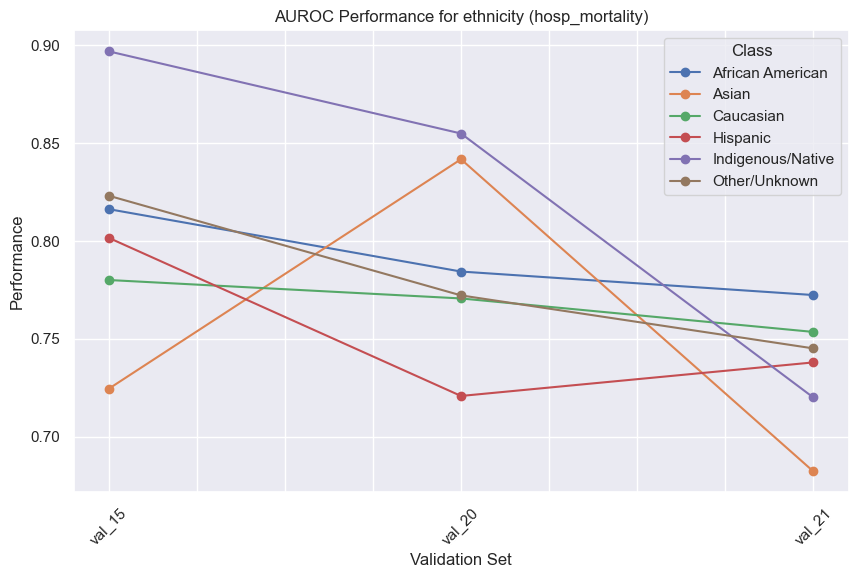

<Figure size 640x480 with 0 Axes>

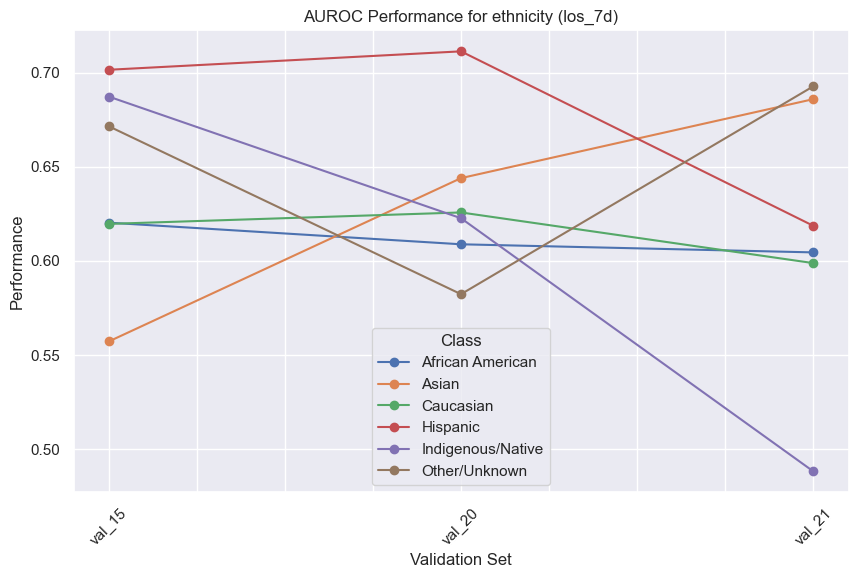

<Figure size 640x480 with 0 Axes>

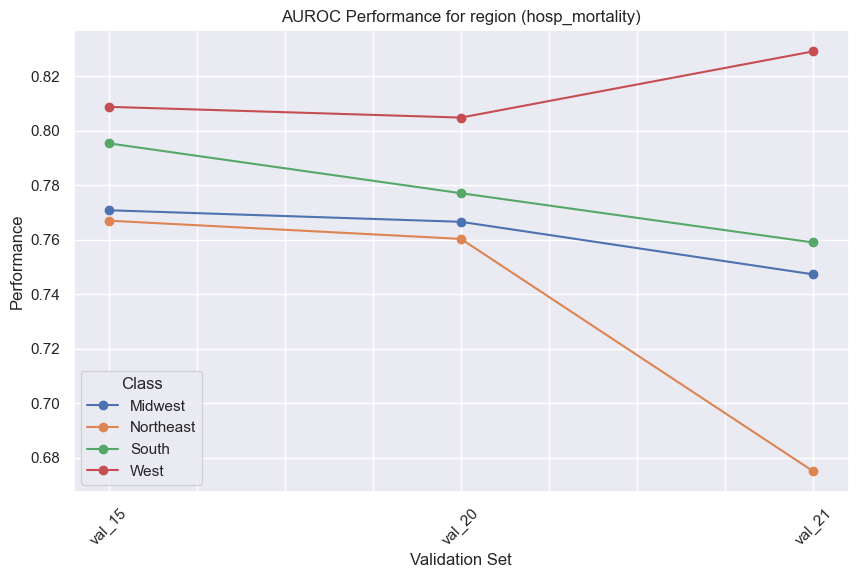

<Figure size 640x480 with 0 Axes>

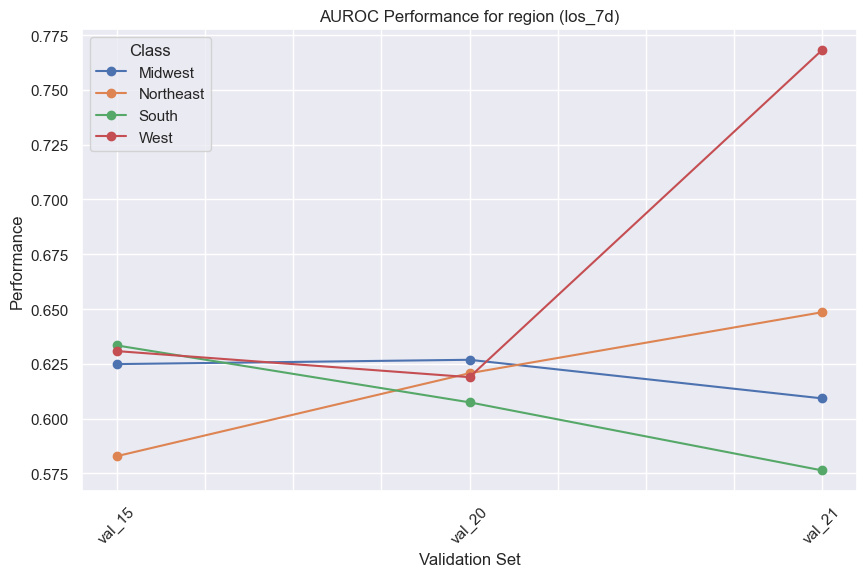

<Figure size 640x480 with 0 Axes>

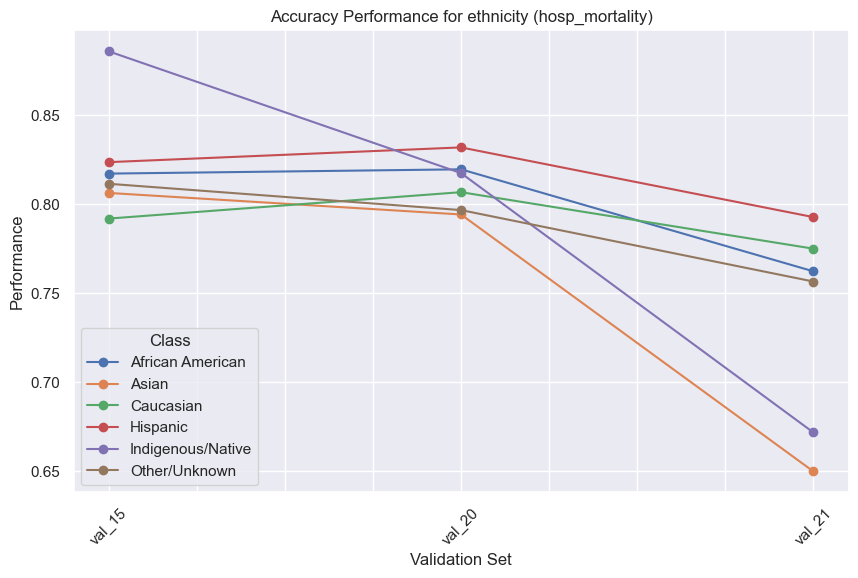

<Figure size 640x480 with 0 Axes>

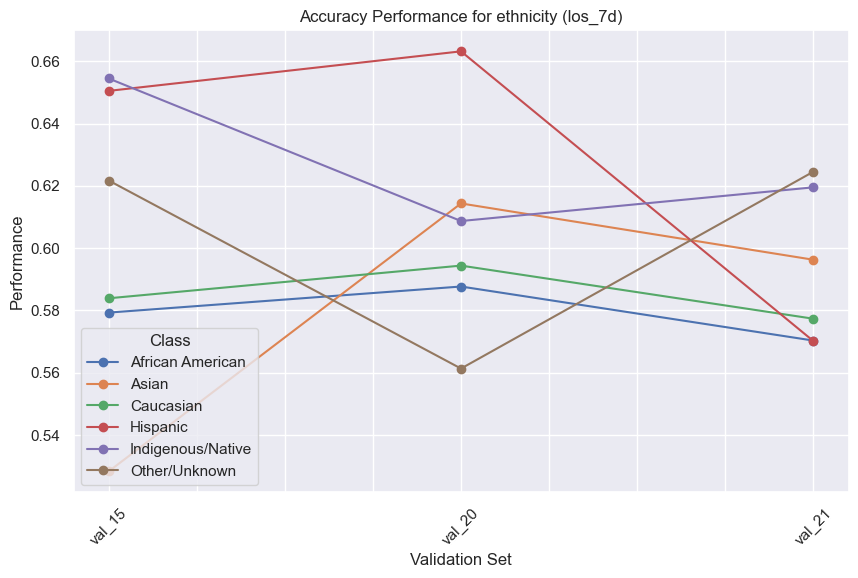

<Figure size 640x480 with 0 Axes>

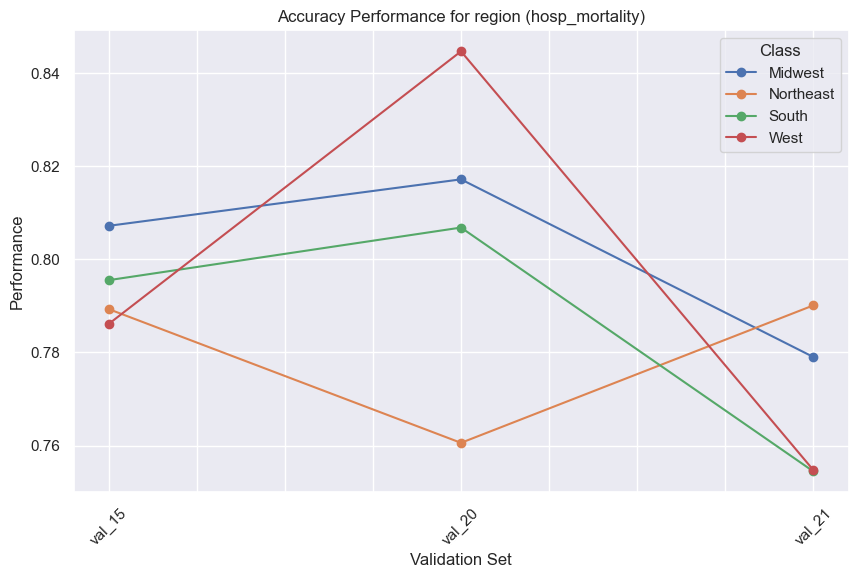

<Figure size 640x480 with 0 Axes>

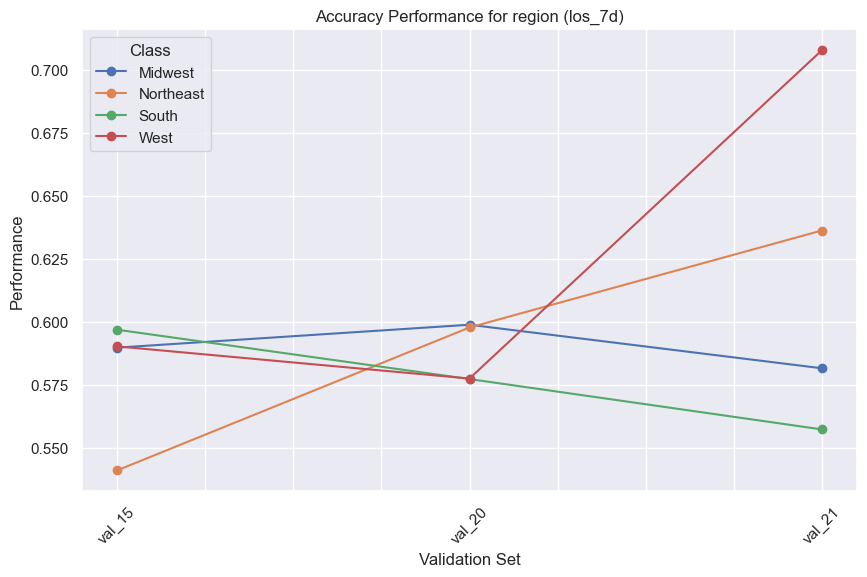

<Figure size 640x480 with 0 Axes>

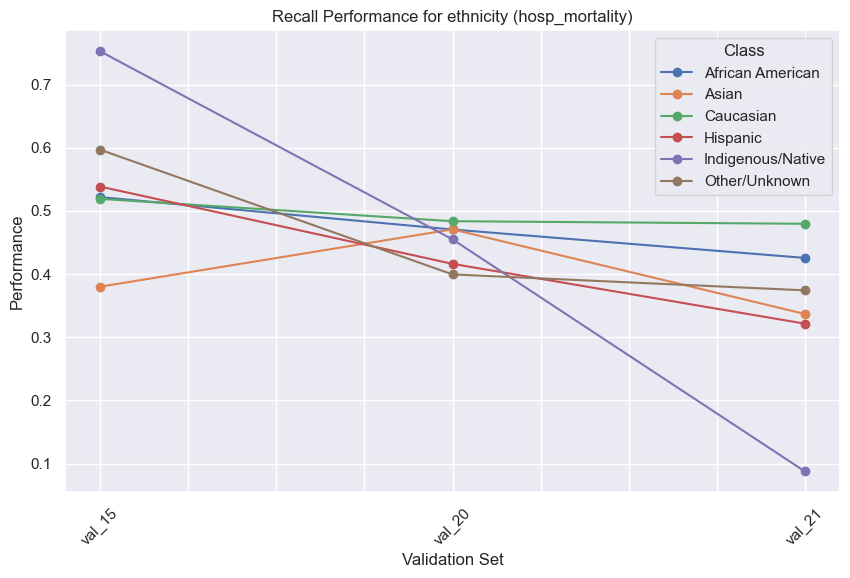

<Figure size 640x480 with 0 Axes>

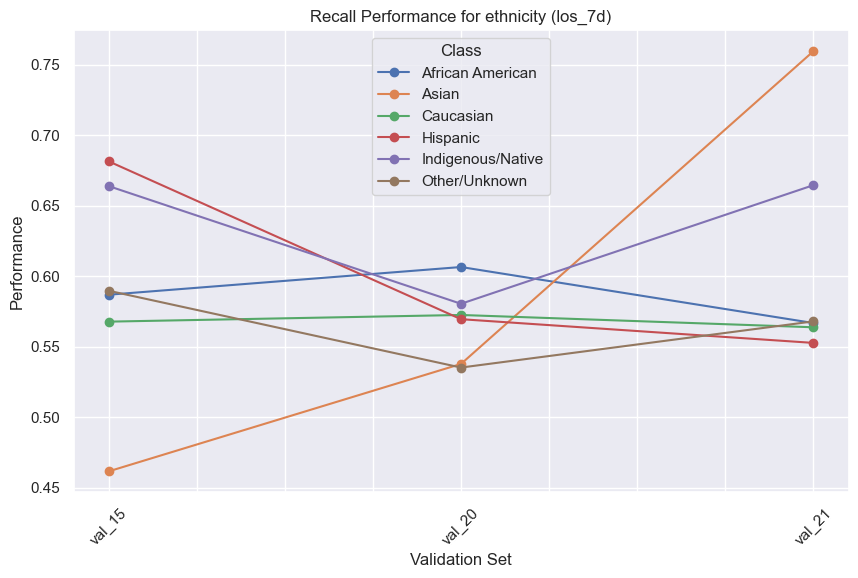

<Figure size 640x480 with 0 Axes>

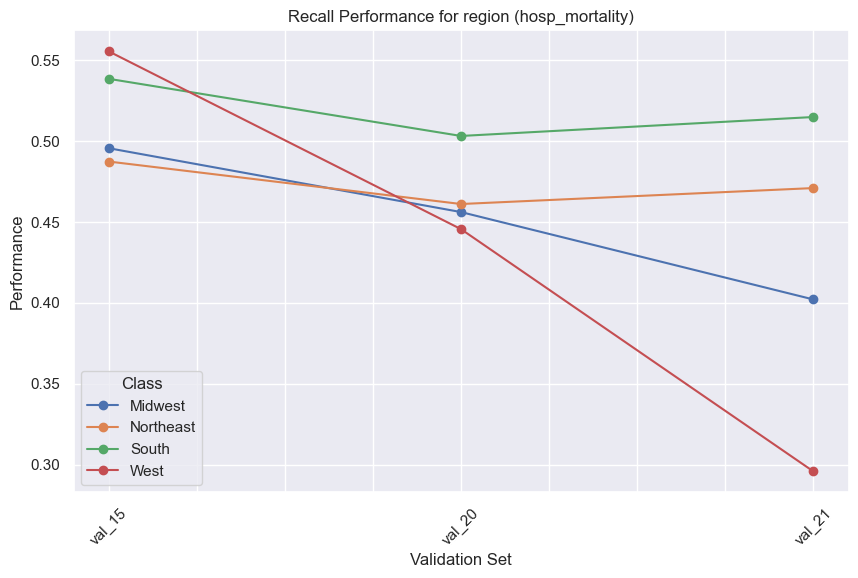

<Figure size 640x480 with 0 Axes>

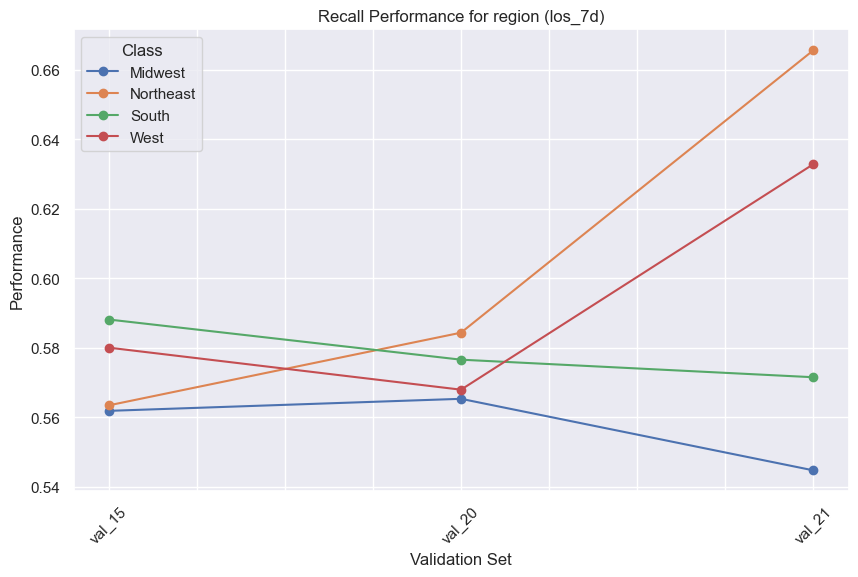

<Figure size 640x480 with 0 Axes>

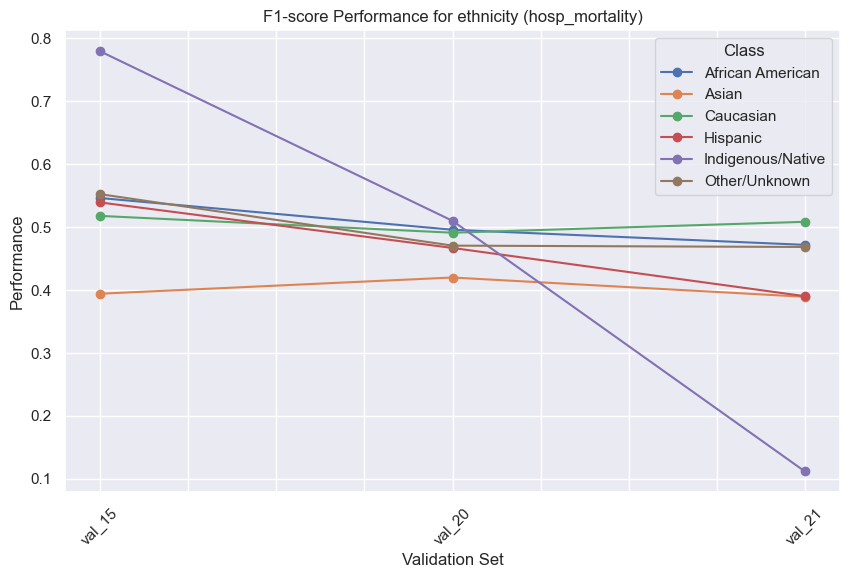

<Figure size 640x480 with 0 Axes>

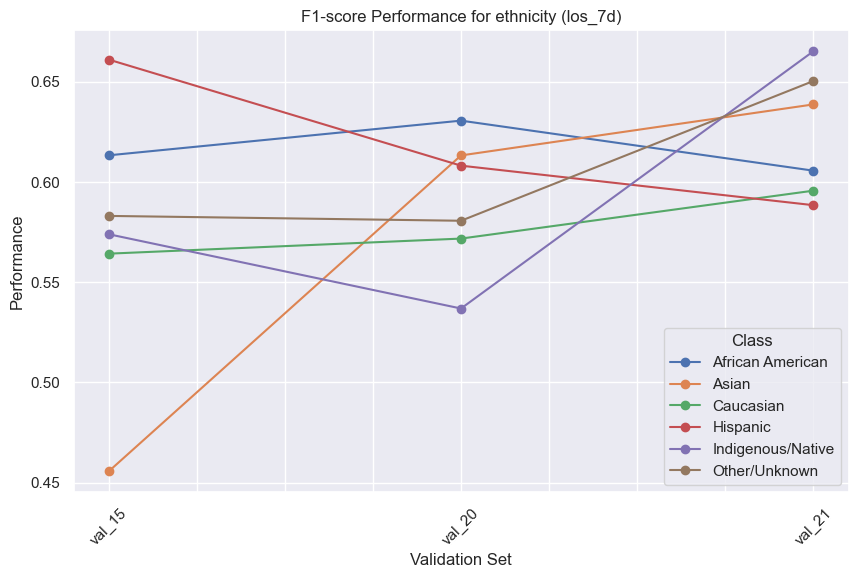

<Figure size 640x480 with 0 Axes>

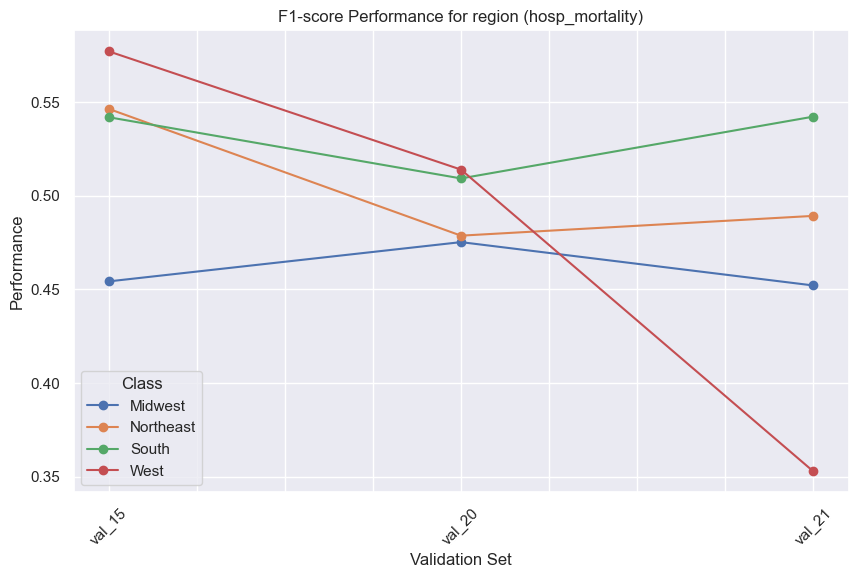

<Figure size 640x480 with 0 Axes>

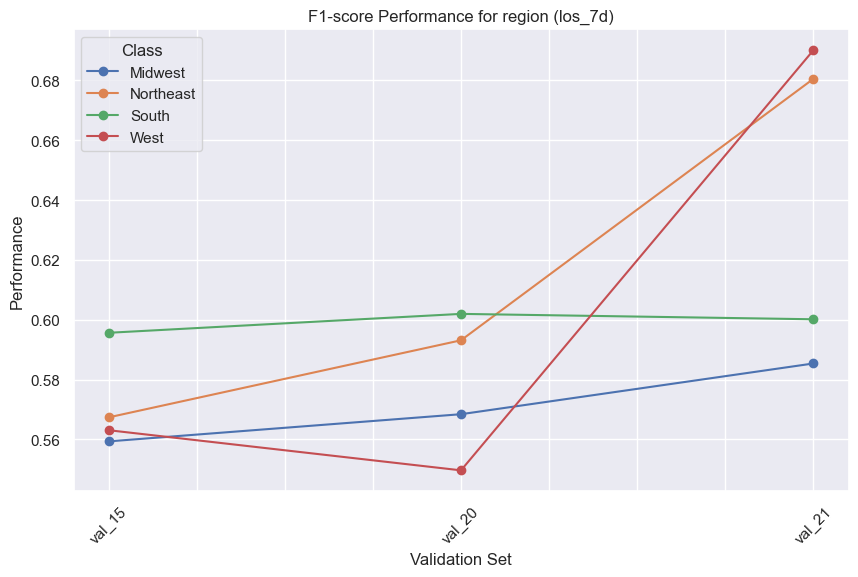

<Figure size 640x480 with 0 Axes>

In [114]:
for metric in metrics:
    for attribute in attributes:
        filtered_df = metrics_all[(metrics_all['Attribute'] == attribute) & (metrics_all['Metric'] == metric)]


        df_grouped = filtered_df[['Task', 'Validation Set', 'Class', 'Value']]

        df_pivot = df_grouped.pivot_table(index='Validation Set', columns='Class', values='Value')

        tasks = df_grouped['Task'].unique()  

        for task in tasks:
            task_df = df_grouped[df_grouped['Task'] == task]  # Filter by task
            task_df_pivot = task_df.pivot_table(index='Validation Set', columns='Class', values='Value')
    
            task_df_pivot.plot(kind='line', marker='o', figsize=(10, 6), title=f"{metric} Performance for {attribute} ({task})")
            plt.ylabel('Performance')
            plt.xlabel('Validation Set')
            plt.xticks(rotation=45)
            plt.legend(title='Class')
            plt.grid(True)
            plt.show()
            plt.savefig(f"{metric} Performance for {attribute} ({task}).jpg")

In [76]:
metrics_all['Metric'].unique()

array(['AUROC', 'Accuracy', 'Recall', 'F1-score',
       'Demographic Parity Ratio', 'Equalized Odds Ratio'], dtype=object)

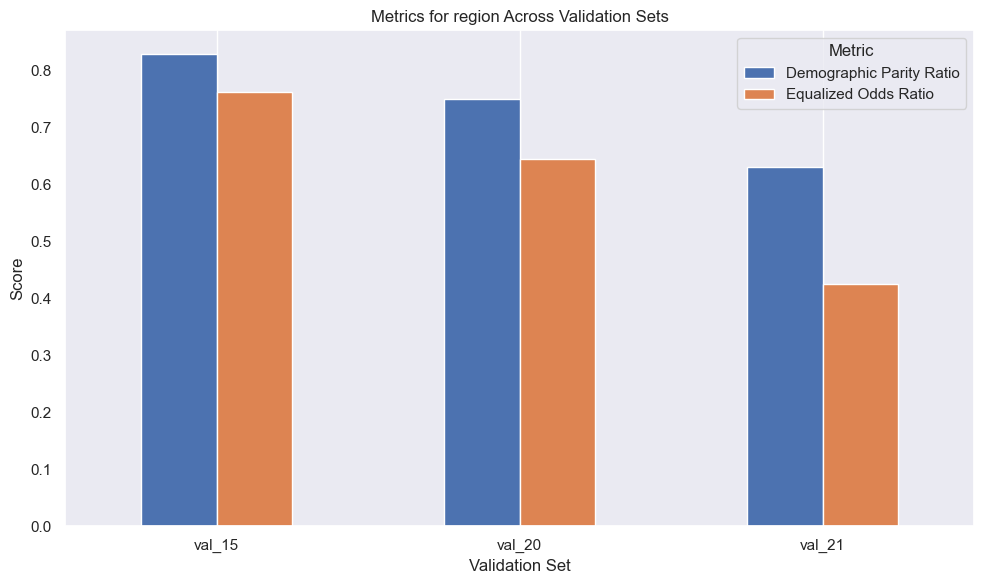

In [115]:
# Attributes and metrics
attribute = 'region'  # or 'region'
metrics_of_interest = ['Demographic Parity Ratio', 'Equalized Odds Ratio']

# Filter the data for the specified attribute and metrics
filtered_df = metrics_all[
    (metrics_all['Attribute'] == attribute) & 
    (metrics_all['Metric'].isin(metrics_of_interest))
]

# Pivot to arrange data for plotting
df_pivot = filtered_df.pivot_table(index='Validation Set', columns='Metric', values='Value')

# Plot
df_pivot.plot(kind='bar', figsize=(10, 6), title=f"Metrics for {attribute} Across Validation Sets")
plt.ylabel('Score')
plt.xlabel('Validation Set')
plt.xticks(rotation=0)
plt.legend(title='Metric', loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()